# Cell 1 - Imports & paths

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Local imports (repo root assumed)
import sys
repo_root = Path("..").resolve()  # notebooks/ is one level down
sys.path.append(str(repo_root / "src"))

from utils import sanity_check_soc_timeseries, pool_consistency_check

In [2]:
# Cell 2 - Load data

In [3]:
data_dir = repo_root / "data" / "synthetic"

soc_timeseries = pd.read_csv(data_dir / "soc_timeseries.csv")
soc_pools = pd.read_csv(data_dir / "soc_pools.csv")
sensitivity = pd.read_csv(data_dir / "sensitivity_results.csv")

soc_timeseries.head(), soc_pools.head(), sensitivity.head()

(   year  scenario  total_soc_tCha  management_change_year  \
 0  2000  baseline       67.109921                    2012   
 1  2001  baseline       66.802287                    2012   
 2  2002  baseline       67.162651                    2012   
 3  2003  baseline       66.918387                    2012   
 4  2004  baseline       66.748424                    2012   
 
    delta_soc_tCha_per_yr  
 0                    NaN  
 1              -0.307635  
 2               0.360365  
 3              -0.244265  
 4              -0.169963  ,
    year  scenario pool  fraction   soc_tCha  pools_sum_tCha
 0  2000  baseline  DPM  0.033296   2.234484       67.109921
 1  2000  baseline  RPM  0.212222  14.242228       67.109921
 2  2000  baseline  BIO  0.035043   2.351738       67.109921
 3  2000  baseline  HUM  0.555145  37.255747       67.109921
 4  2000  baseline  IOM  0.164294  11.025724       67.109921,
                      parameter  impact  rank
 0            carbon_input_rate    0.34     

# Cell 3 - Sanity checks

In [4]:
checks = sanity_check_soc_timeseries(soc_timeseries)
checks

{'min_soc': 66.59004215068333,
 'max_soc': 69.50512817172577,
 'has_negative_soc': False,
 'extreme_delta_count': 0}

# Cell 4 — Plot SOC trajectories (baseline vs project)

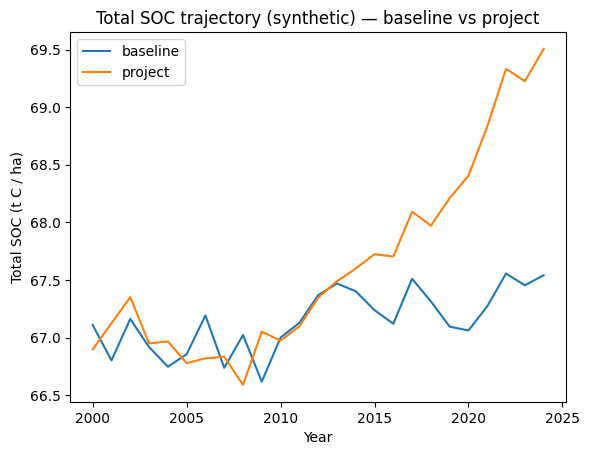

In [5]:
for scenario in soc_timeseries["scenario"].unique():
    df_s = soc_timeseries[soc_timeseries["scenario"] == scenario]
    plt.plot(df_s["year"], df_s["total_soc_tCha"], label=scenario)

plt.xlabel("Year")
plt.ylabel("Total SOC (t C / ha)")
plt.title("Total SOC trajectory (synthetic) — baseline vs project")
plt.legend()
plt.show()

# Cell 5 — Year-on-year ΔSOC

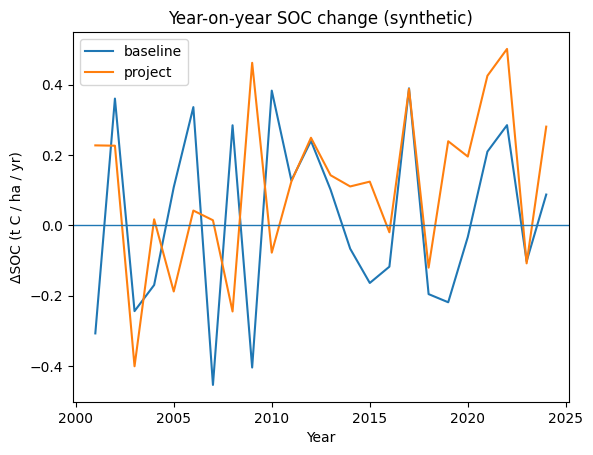

In [6]:
for scenario in soc_timeseries["scenario"].unique():
    df_s = soc_timeseries[soc_timeseries["scenario"] == scenario]
    plt.plot(df_s["year"], df_s["delta_soc_tCha_per_yr"], label=scenario)

plt.axhline(0, linewidth=1)
plt.xlabel("Year")
plt.ylabel("ΔSOC (t C / ha / yr)")
plt.title("Year-on-year SOC change (synthetic)")
plt.legend()
plt.show()

# Cell 6 — Pool-level plots (quick scan)

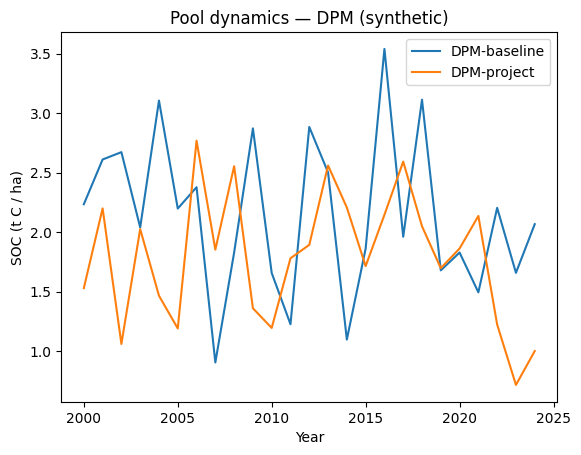

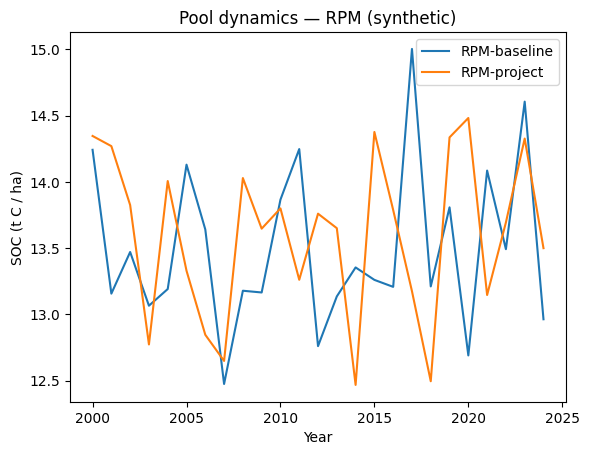

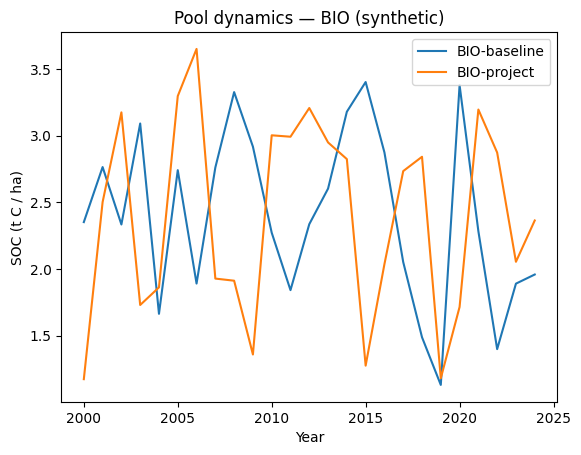

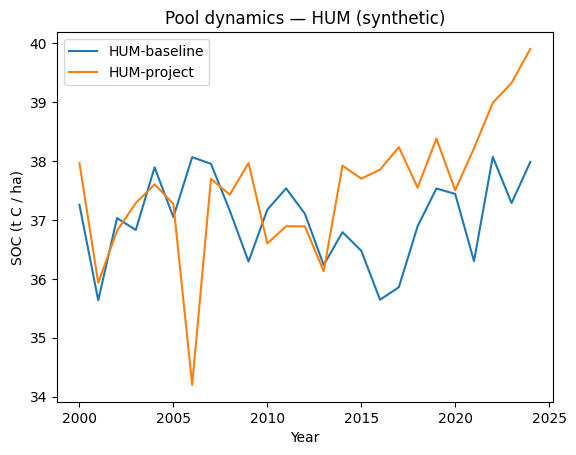

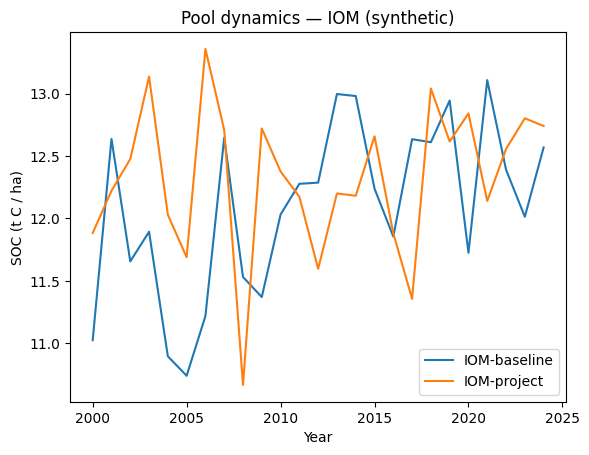

In [7]:
pools = soc_pools["pool"].unique()

for pool in pools:
    df_p = soc_pools[soc_pools["pool"] == pool]
    for scenario in df_p["scenario"].unique():
        df_ps = df_p[df_p["scenario"] == scenario]
        plt.plot(df_ps["year"], df_ps["soc_tCha"], label=f"{pool}-{scenario}")
    plt.xlabel("Year")
    plt.ylabel("SOC (t C / ha)")
    plt.title(f"Pool dynamics — {pool} (synthetic)")
    plt.legend()
    plt.show()

# Cell 7 — Pool consistency check

In [8]:
consistency = pool_consistency_check(soc_pools, soc_timeseries)
consistency.head(10)

,scenario,year,soc_tCha,total_soc_tCha,abs_diff,rel_diff
0,baseline,2000,67.109921,67.109921,0.000000e+00,0.000000e+00
1,baseline,2001,66.802287,66.802287,0.000000e+00,0.000000e+00
2,baseline,2002,67.162651,67.162651,0.000000e+00,0.000000e+00
3,baseline,2003,66.918387,66.918387,0.000000e+00,0.000000e+00
4,baseline,2004,66.748424,66.748424,0.000000e+00,0.000000e+00
5,baseline,2005,66.856512,66.856512,0.000000e+00,0.000000e+00
6,baseline,2006,67.192580,67.192580,1.421085e-14,2.114944e-16
7,baseline,2007,66.738409,66.738409,1.421085e-14,2.129337e-16
8,baseline,2008,67.022866,67.022866,1.421085e-14,2.120299e-16
9,baseline,2009,66.618164,66.618164,1.421085e-14,2.133180e-16


In [9]:
# Quick summary: max relative diff
consistency["rel_diff"].max()

np.float64(2.1340810511945555e-16)

# Cell 8 — Sensitivity table

In [10]:
sensitivity.sort_values("rank")

,parameter,impact,rank
0,carbon_input_rate,0.34,1
1,clay_content,0.28,2
2,temperature_response,0.16,3
3,moisture_modifier,0.12,4
4,decomposition_rate_modifier,0.10,5


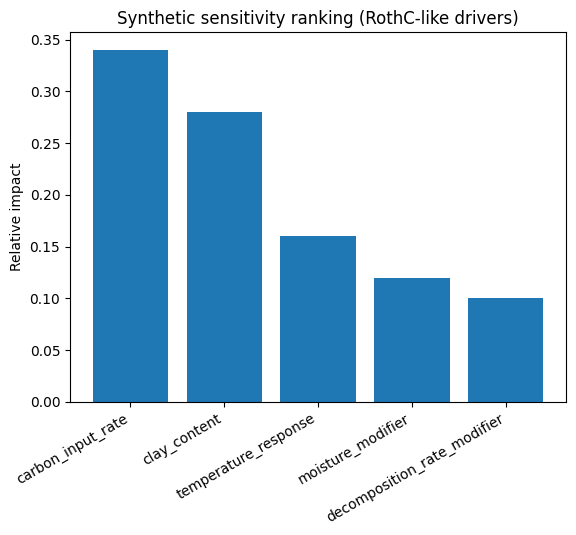

In [11]:
plt.bar(sensitivity["parameter"], sensitivity["impact"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Relative impact")
plt.title("Synthetic sensitivity ranking (RothC-like drivers)")
plt.show()

# Cell 9 — Fitness-for-use decision matrix 

## Fitness-for-use decision matrix

**Decision rule (conservative):**
If uncertainty materially overlaps with zero sequestration, results must be downscaled, caveated, or excluded from external claims.

| Use case | Fit? | Rationale |
|---|---|---|
| Internal exploration | Yes | Synthetic outputs are internally consistent and agronomically plausible. Suitable for testing workflows, reviewing plausibility, and training internal decision logic. |
| External reporting | No | Absence of measured SOC validation data and explicit uncertainty bounds prevents defensible external reporting. Results require downscaling and additional validation. |
| Verification & audit | No | Synthetic data and lack of site-specific evidence make results not fit for verification-grade use. Case is audit-aware but not audit-ready. |

**Conclusion:**
This case demonstrates how technically plausible model outputs may still be unfit for external use when uncertainty, validation gaps, and data provenance are not adequately addressed.